In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d akash2sharma/tiny-imagenet

 96% 454M/474M [00:03<00:00, 151MB/s]
100% 474M/474M [00:03<00:00, 133MB/s]


In [ ]:
!unzip /content/tiny-imagenet.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_5500.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5501.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5502.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5503.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5504.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5505.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5506.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5507.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5508.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5509.JPEG  
  inflating: tiny-imagenet-200/val/images/val_551.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5510.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5511.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5512.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5513.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5514.JPEG  
  inflating: tiny-imag

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2

In [ ]:
Resnet = ResNet50V2(include_top=False, weights=None,
    input_shape=(256,256,3),
    pooling=None)

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential

layer_name = 'conv4_block6_out'
layer_output = Resnet.get_layer(name = layer_name).output
intermediate_model=tf.keras.models.Model(inputs=Resnet.input,outputs=layer_output)
backbone = Sequential()
backbone.add(intermediate_model)

In [ ]:
backbone.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8, 8, 1024)        8573440   
Total params: 8,573,440
Trainable params: 8,548,480
Non-trainable params: 24,960
_________________________________________________________________


In [ ]:
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, ReLU, add, Flatten, Activation

def upsample(filters, size, stride, shape, apply_dropout = False, last_layer=False):

    initializer = tf.random_normal_initializer(0.,0.02)

    result = Sequential()

    result.add(Conv2DTranspose(filters,size,strides=stride,padding='same',batch_input_shape=shape,kernel_initializer=initializer, use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:

        result.add(Dropout(0.5))

    if last_layer:
      result.add(Activation('tanh'))
      print("yay last layer")
    else:
      result.add(ReLU())

    return result

In [ ]:
head1 = Sequential()

head1.add(backbone)
head1.add(upsample(256,4,1,(None,8,8,1024),apply_dropout=True))
head1.add(upsample(128,4,2,(None,8,8,256),apply_dropout=True))
head1.add(upsample(64,4,1,(None,16,16,128)))
head1.add(upsample(32,4,2,(None,16,16,64)))
head1.add(upsample(1,4,1,(None,32,32,32),last_layer=True))
head1.add(Flatten())

yay last layer


In [ ]:
head2 = Sequential()

head2.add(backbone)
head2.add(upsample(256,4,1,(None,8,8,1024),apply_dropout=True))
head2.add(upsample(128,4,2,(None,8,8,256),apply_dropout=True))
head2.add(upsample(64,4,1,(None,16,16,128)))
head2.add(upsample(32,4,2,(None,16,16,64)))
head2.add(upsample(1,4,1,(None,32,32,32), last_layer=True))
head2.add(Flatten())

yay last layer


In [ ]:
head1.load_weights('/content/drive/MyDrive/SSL_small/head1_51.h5')
head2.load_weights('/content/drive/MyDrive/SSL_small/head2_51.h5')

In [ ]:
head1.layers[0].trainable = False
head2.layers[0].trainable = False

In [ ]:
for l in head1.layers:
    print(l.name, l.trainable)

for l in head2.layers:
    print(l.name, l.trainable)

sequential False
sequential_2 True
sequential_3 True
sequential_4 True
sequential_5 True
sequential_6 True
flatten True
sequential False
sequential_8 True
sequential_9 True
sequential_10 True
sequential_11 True
sequential_12 True
flatten_1 True


In [ ]:
head1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8, 8, 1024)        8573440   
_________________________________________________________________
sequential_2 (Sequential)    (None, 8, 8, 256)         4195328   
_________________________________________________________________
sequential_3 (Sequential)    (None, 16, 16, 128)       524800    
_________________________________________________________________
sequential_4 (Sequential)    (None, 16, 16, 64)        131328    
_________________________________________________________________
sequential_5 (Sequential)    (None, 32, 32, 32)        32896     
_________________________________________________________________
sequential_6 (Sequential)    (None, 32, 32, 1)         516       
_________________________________________________________________
flatten (Flatten)            (None, 1024)             

In [ ]:
import shutil

shutil.rmtree('/content/tiny-imagenet-200/tiny-imagenet-200')

In [ ]:
x = tf.keras.Input(name="input", shape= (256,256,3))

y1 = head1(x)
y2 = head2(x)

y = tf.keras.layers.Concatenate(axis=-1)([y1,y2])
y = tf.keras.layers.Dense(512)(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = tf.keras.layers.Dense(200)(y)
y = tf.keras.layers.BatchNormalization()(y)
y_out = tf.keras.layers.Softmax()(y)

MLP = tf.keras.Model(inputs=x, outputs=y_out)

In [ ]:
MLP.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         13458308    input[0][0]                      
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 1024)         13458308    input[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2048)         0           sequential_1[0][0]               
                                                                 sequential_7[0][0]         

In [ ]:
batch_size = 8
img_height = 256
img_width = 256
data_dir = '/content/tiny-imagenet-200/train'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.0,
  shuffle = True, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100000 files belonging to 200 classes.


In [ ]:
train_ds1 = train_ds

In [ ]:
class_names = train_ds.class_names
print(class_names)

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684'

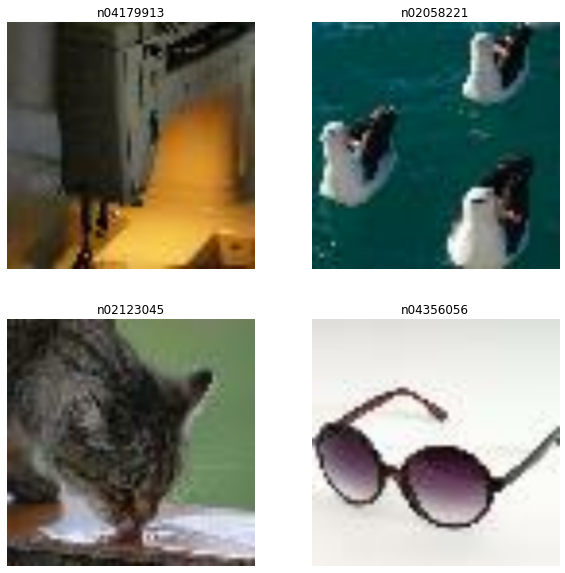

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
import keras
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
MLP.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
MLP.load_weights('/content/drive/MyDrive/SSL_MLP/weights900000009.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/SSL_MLP/weights9{epoch:08d}.h5', save_weights_only=True, save_freq='epoch')

epochs=100
history = MLP.fit(
  train_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/100
12500/12500 [==============================] - 2045s 160ms/step - loss: 4.9891 - accuracy: 0.3280
Epoch 2/100
12500/12500 [==============================] - 2016s 160ms/step - loss: 4.9870 - accuracy: 0.3291
Epoch 3/100
12500/12500 [==============================] - 2018s 161ms/step - loss: 4.9857 - accuracy: 0.3313
Epoch 4/100
12500/12500 [==============================] - 2023s 161ms/step - loss: 4.9839 - accuracy: 0.3330
Epoch 5/100
12500/12500 [==============================] - 2030s 162ms/step - loss: 4.9824 - accuracy: 0.3341
Epoch 6/100
12500/12500 [==============================] - 2035s 162ms/step - loss: 4.9838 - accuracy: 0.3322
Epoch 7/100
12500/12500 [==============================] - 2019s 161ms/step - loss: 4.9809 - accuracy: 0.3358
Epoch 8/100
12500/12500 [==============================] - 2032s 162ms/step - loss: 4.9810 - accuracy: 0.3355
Epoch 9/100
12500/12500 [==============================] - 2040s 162ms/step - loss: 4.9797 - accuracy: 0.3372
Epoch 10/1

KeyboardInterrupt: ignored

In [ ]:
MLP.save_weights('/content/drive/MyDrive/SSL_MLP/10.h5')

# Testing

In [ ]:
classes = train_ds1.class_names

200

In [ ]:
import cv2 
import numpy as np
import glob
from tqdm import tqdm
with open('val2.txt','w') as f:
    for path in glob.glob('/content/tiny-imagenet-200/val/images/*'):
      im = cv2.imread(path)
      # im = im/255
      im = cv2.resize(im,(256,256))
      out = MLP.predict(np.expand_dims(im , axis=0))
      pred = class_names[np.argmax(out)]
      f.write(path.split('/')[-1] + ' ' + pred +'\n')    
    f.close()

In [ ]:
with open('/content/tiny-imagenet-200/val/val_annotations.txt','r') as f:
    dic = {}
    lines = f.readlines()
    for line in lines:
      dic[line.split('\t')[0]] = line.split('\t')[1]
    f.close()

In [ ]:
with open('val2.txt','r') as f:
    dic3 = {}
    lines = f.readlines()
    for line in lines:
      dic3[line.split()[0]] = line.split()[1]
    f.close()

In [ ]:
cnt = 0
arr = []
for x in dic.keys():
  if dic[x] == dic3[x]:
    cnt+=1
  else:
    arr.append([dic[x] ,dic3[x]])
print(cnt)

503


In [ ]:
arr

[['n03444034', 'n03599486'],
 ['n04067472', 'n09193705'],
 ['n04070727', 'n01910747'],
 ['n02808440', 'n03977966'],
 ['n04399382', 'n03706229'],
 ['n04179913', 'n03670208'],
 ['n02823428', 'n02730930'],
 ['n04146614', 'n03179701'],
 ['n02226429', 'n09256479'],
 ['n04371430', 'n03706229'],
 ['n07753592', 'n02074367'],
 ['n02226429', 'n02481823'],
 ['n03770439', 'n03355925'],
 ['n02056570', 'n07749582'],
 ['n02906734', 'n04562935'],
 ['n02125311', 'n02486410'],
 ['n04486054', 'n02481823'],
 ['n04285008', 'n02808440'],
 ['n03763968', 'n04562935'],
 ['n03814639', 'n02481823'],
 ['n03837869', 'n02056570'],
 ['n01983481', 'n02481823'],
 ['n01629819', 'n01984695'],
 ['n04532670', 'n07715103'],
 ['n04074963', 'n02814860'],
 ['n04540053', 'n01950731'],
 ['n04371430', 'n04149813'],
 ['n02906734', 'n03444034'],
 ['n02094433', 'n02124075'],
 ['n03796401', 'n03977966'],
 ['n07614500', 'n02917067'],
 ['n03837869', 'n02808440'],
 ['n03937543', 'n01910747'],
 ['n06596364', 'n04562935'],
 ['n02977058',

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus
import cv2
from PIL import Image
import re
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


def GradCP(corr_label,model,weight_path, paths,result_name):

    '''
        Return grad cam ++ results on image passed
            Parameters:
                model_name: name of model user passes
                corr_label: class of the image
                weight_path: weights to use
                image_path: path of all images in txt file
                result: str
                
    '''

    def loss(output):
        #return score of label class as loss
        return (output[0][corr_label])

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    num_classes = 1

    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    model.load_weights(weight_path)
    i = 0
    grad_result_path = []
    for image_path in paths:
   
        '''
        #image = cv2.imread(image_path)
        print(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_fromarray = Image.fromarray(image, 'RGB')
        image = image_fromarray.resize((IMG_HEIGHT , IMG_WIDTH))
        image = np.array(image)/255
        image = np.expand_dims(image, axis=0)
        '''
        image = np.load(image_path)
        # Create GradCAM++ object
        gradcam = GradcamPlusPlus(model,model_modifier,clone=False)

        # Generate heatmap with GradCAM++
        cam = gradcam(loss,
                    image,
                    penultimate_layer=-1, # model.layers number
                    )

        cam = normalize(cam)
        # f, ax = plt.subplots(**subplot_args)
        # for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        plt.axis("off")
        plt.grid(None)
        plt.imshow(image[0])
        plt.imshow(heatmap, cmap='jet', alpha=0.4)

        grad_result_path.append('./Results/GradCamResults/' + result_name + "_"+str(i)+'.png')
        plt.savefig(grad_result_path[-1],bbox_inches='tight')
        plt.close()

        i += 1

    return grad_result_path


In [ ]:
import numpy as np
import keras
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import cv2
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import imageio


def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image


def Lime(model,weight_path, paths,result_name):
    '''
    Return lime results on image passed
            Parameters:
                model_name: name of model user passes
                result: str
                weight_path: weights to use
                image_path: path of the image
    '''
    lime_result_path = []
    i = 0
    for image_path in paths:

        image = np.load(image_path)

        #Generating super pixels
        superpixels = skimage.segmentation.quickshift(image, kernel_size=2,max_dist=20, ratio=0.5)
        num_superpixels = np.unique(superpixels).shape[0]

        #Create Random Perturbations
        num_perturb = 500
        perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

        predictions = []
        for pert in perturbations:
            perturbed_img = perturb_image(image,pert,superpixels)
            pred = model.predict(perturbed_img[np.newaxis,:,:,:])
            predictions.append(pred)

        #Predicted classes of new generated images
        predictions = np.array(predictions)
        original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
        distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

        kernel_width = 0.25
        weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

        #Get the top class
        preds = model.predict(np.expand_dims(image,axis = 0))
        class_to_explain = preds[0]
        simpler_model = LinearRegression()
        simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
        coeff = simpler_model.coef_[0]

        num_top_features = 3
        top_features = np.argsort(coeff)[-num_top_features:]

        mask = np.zeros(num_superpixels) 
        mask[top_features]= True #Activate top superpixels 

        final = (perturb_image(image,mask,superpixels)*255)
        final = final.astype(np.uint8)

        lime_result_path.append(result_name + "_"+str(i)+'.png')
        imageio.imwrite(lime_result_path[-1], final)
        i += 1

    return lime_result_path


In [ ]:
paths = ['/content/drive/MyDrive/Kiti-Single/0.npy', '/content/drive/MyDrive/Kiti-Single/1.png']
model = head2
weight_path = '/content/drive/MyDrive/SSL_small/head2_51.h5'
result_name = 'trail'
f = Lime(model,weight_path, paths,result_name)